<a href="https://colab.research.google.com/github/User-XXI/ITAI/blob/main/Labs_ITAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа № 1**

In [ ]:
from abc import ABC, abstractmethod
from typing import List
import itertools
import math
import matplotlib.pyplot as plt

class Neuron(ABC):
    """
    Абстрактный класс нейрона.
    Аргументы:
    weights -- массив начальных весов.
    learning_rate -- норма обучения (0; 1].
    t -- целевой выход.
    Атрибуты:
    X -- массив всех наборов от 4 переменных.
    """

    def __init__(self, weights: List[float], t: List[int], learning_rate: float = 0.3):
        assert len(weights) == 5, "Неверная длина массива весов."
        self.weights = weights

        assert 0 < learning_rate <= 1, "Норма обучения должна быть в диапазоне (0, 1]."
        self.learning_rate = learning_rate

        assert len(t) == 16, "Неверная длина целевого вектора."
        self.t = t

        self.X = list(itertools.product([0, 1], repeat=4))

    @abstractmethod
    def train(self):
        pass

    @abstractmethod
    def feedforward(self, x: List[int]) -> int:
        pass

    def result(self) -> List[int]:
        """
        Вычисляет результат для каждого набора в X на основе функции активации и текущих весов.
        :return: Результат функции для текущей эпохи.
        """
        return [self.feedforward(x) for x in self.X]

    def hamming_distance(self, y: List[int]) -> int:
        """
        Вычисляет расстояние Хемминга между вектором y и целевым вектором t.
        :param y: Вектор для сравнения с целевым вектором t.
        :return: Расстояние Хемминга.
        """
        return sum(el1 ^ el2 for el1, el2 in zip(y, self.t))

    @staticmethod
    def plot(epochs: int, E: List[int], title: str):
        plt.title(title)
        plt.xlabel("Эпоха")
        plt.ylabel("Ошибка E")
        plt.grid()
        plt.plot(range(epochs + 1), E)
        plt.show()

    @staticmethod
    def bin_to_dec(number: List[int]) -> int:
        """
        Преобразует двоичное число в десятичное.
        :param number: Двоичное число в виде списка цифр.
        :return: Десятичное представление числа.
        """
        return int(''.join(map(str, number)), 2)


class NeuronWithUnitStepFunction(Neuron):
    """
    Класс реализует нейрон с пороговой функцией активации.
    """

    def update_weights(self, input_set, error):
        """
        Обновляет веса нейрона на основе входных данных и ошибки.
        """
        self.weights = [w + self.learning_rate * error * (1 if j == 0 else input_set[j - 1])
                        for j, w in enumerate(self.weights)]

    def train(self):
        """
        Функция обучения.
        """
        epochs = 100
        E_list = []

        for epoch in range(epochs):
            Y = self.result()
            E = self.hamming_distance(Y)
            print(f"Эпоха {epoch}: Y = {Y}, W = {self.weights} E = {E}")
            E_list.append(E)

            if E == 0:
                self.plot(epoch, E_list, "Зависимоть E от k")
                break

            for i, input_set in enumerate(self.X):
                error = self.t[i] - self.feedforward(input_set)
                self.update_weights(input_set, error)

    def feedforward(self, x) -> int:
        """
        Вычисляет значение функции на наборе x.
        :param x: Набор для вычисления функции.
        :return: Значение функции f(net).
        """
        net = sum(w * xi for w, xi in zip(self.weights[1:], x)) + self.weights[0]
        return 1 if net >= 0 else 0


class NeuroneWithSigmoidActivationFunction(Neuron):
    """
    Класс реализующий нейрон с сигмоидальной функцией активации
    """

    def adjust_weights(self, input_set, delta, derivative):
        """
        Обновляет веса на основе разности выхода и целевого значения, а также производной сигмоидальной функции.
        """
        for j in range(len(self.weights)):
            input_value = 1 if j == 0 else input_set[j - 1]
            self.weights[j] += self.learning_rate * delta * derivative * input_value


    def train(self, X=None, logging=True) -> bool:
        """
        Функция обучения нейрона.
        :param X: Наборы обучающей выборки.
        :param logging: Печать информации об эпохе в консоль (Да/Нет).
        :return: Успех обучения (True, если обучение успешно завершилось).
        """
        if X is None:
            X = self.X

        epochs = 300
        E_list = []
        for epoch in range(epochs):
            Y = self.result()
            E = self.hamming_distance(Y)
            E_list.append(E)
            if logging:
                print(f"Эпоха {epoch}: Y = {Y}, W = {self.weights}, E = {E}")

            if E == 0:
                if logging:
                    self.plot(epoch, E_list, "Зависимость E от k")
                return True

            for input_set in X:
                y = self.feedforward(input_set)
                delta = self.t[self.bin_to_dec(input_set)] - y
                out = self.sigmoid_function(input_set)
                derivative = out * (1 - out)
                self.adjust_weights(input_set, delta, derivative)

        return False

    def train_partly(self):
        """
        Обучение на неполной выборке, итерация через все возможные сочетания входных данных.
        """
        for i in range(2, 16):
            for item in itertools.combinations(self.X, i):
                self.weights = [0, 0, 0, 0, 0]
                successful_learning = self.train(item, False)
                if successful_learning:
                    print(f"Набор из {i} векторов: {item}")
                    self.weights = [0, 0, 0, 0, 0]  # Повторная инициализация весов
                    self.train(item, True)  # Повторное обучение с логированием
                    return  # Останавливаемся после успешного обучения


    def feedforward(self, x) -> int:
        """
        Вычисление y(out)
        :param x: Набор на котором необходимо вычислить функцию
        :return: y(out)
        """
        return 1 if self.sigmoid_function(x) >= 0.5 else 0

    def sigmoid_function(self, x) -> float:
        """
        Вычисление out (сигмоидальной функции)
        :param x: набор на котором необходимо посчитать функцию
        :return: значение сигмоидальной функции f(net) на наборе x
        """
        net = 0
        for i, w in enumerate(self.weights[1:]):
            net += w * x[i]
        net += self.weights[0]
        return 0.5 * ((net / (1 + abs(net))) + 1)

    def sigmoid_function(self, x) -> float:
      """
      Вычисляет значение сигмоидальной функции активации для заданного входного набора x.
      :param x: Набор входных данных.
      :return: Значение сигмоидальной функции f(net) для входного набора x.
      """
      net = sum(w * xi for w, xi in zip(self.weights[1:], x)) + self.weights[0]
      return 0.5 * ((net / (1 + abs(net))) + 1)




print("Вариант №7")
result_vector = [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
print("Задание №1 - Обучение с пороговой функцией активации")
n = NeuronWithUnitStepFunction([0, 0, 0, 0, 0], result_vector)
n.train()
print('\n' + '=' * 100)
print("Задание №2 - Обучение с сигмоидальной функцией активации")
n2 = NeuroneWithSigmoidActivationFunction([0, 0, 0, 0, 0], result_vector)
n2.train()
print('\n' + '=' * 100)
print("Задание №3 - Обучение с сигмоидальной функцией активации и неполной выборкой")
n3 = NeuroneWithSigmoidActivationFunction([0, 0, 0, 0, 0], result_vector)
n3.train_partly()






**Лабораторная работа № 3**

Вариант №7


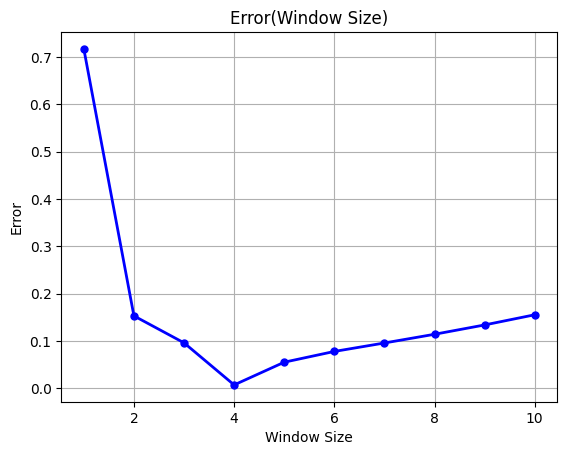

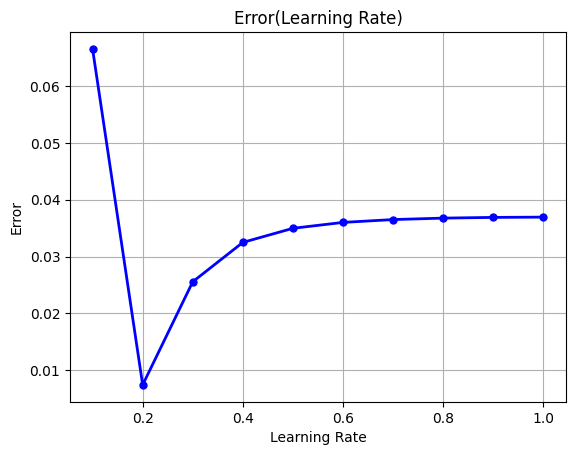

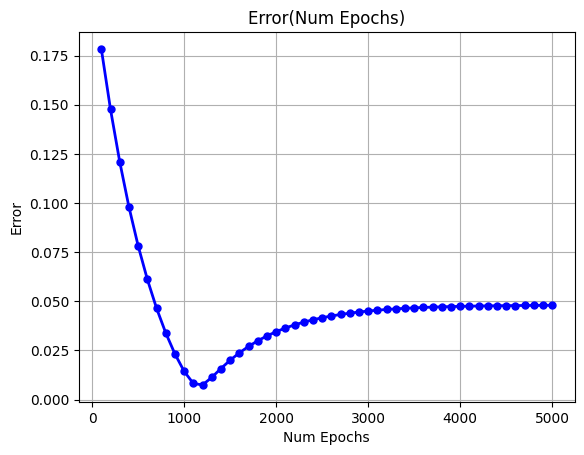

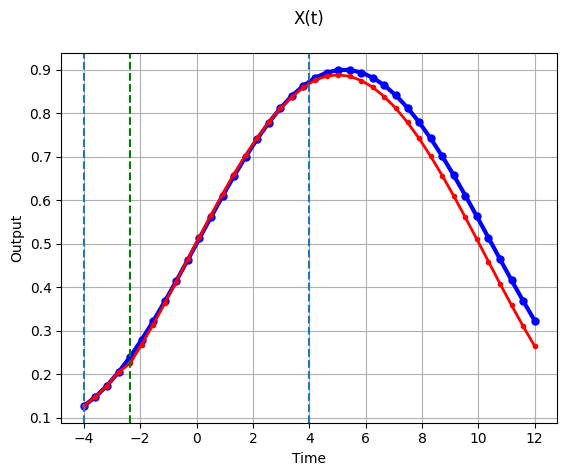

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_function_output(time_points):
    """Возвращает результат моделируемой функции от значения времени"""
    return [0.4 * np.sin(0.3 * t) + 0.5 for t in time_points]

num_data_points = 20  # количество точек
interval_start = -4  # начало интервала
interval_end = 4  # конец интервала

time_series = list(np.linspace(interval_start, 2 * interval_end - interval_start, 2 * num_data_points))
model_output = get_function_output(time_series)
predicted_output = [0 for _ in range(num_data_points)]

def calculate_weight_adjustment(input_value, error, learning_rate):
    """Находит величину, на которую изменятся веса"""
    return learning_rate * error * input_value

def calculate_network_input(inputs, weights):
    """Находит значение сетевого входа нейронной сети"""
    return sum(weight * input_val for weight, input_val in zip(weights, inputs))

def calculate_mean_square_error(true_output, predicted_output, window_size):
    error_sum = sum((true_val - predicted_val) ** 2
                    for true_val, predicted_val
                    in zip(true_output[window_size:], predicted_output[window_size:]))
    mse = error_sum / (len(true_output) - window_size)
    return mse ** 0.5

def train_neural_network(window_size, learning_rate, num_epochs):
    """Обучение нейросети методом скользящего окна"""
    for index in range(window_size):
        predicted_output[index] = model_output[index]

    network_weights = [0] * window_size
    epoch = 0

    while epoch < num_epochs:
        for step in range(window_size, num_data_points):
            window_input = model_output[step - window_size:step - 1]
            predicted_output[step] = calculate_network_input(window_input, network_weights)
            training_error = model_output[step] - predicted_output[step]

            for weight_index in range(window_size):
                input_val = model_output[step - window_size + weight_index]
                network_weights[weight_index] += calculate_weight_adjustment(input_val, training_error, learning_rate)

        epoch += 1

    # print(np.around(predicted_output, 3))
    return predicted_output, network_weights

def plot_results(predicted_output, window_size, arg="", title=""):
    """Строит графики модели и предсказаний"""
    fig, ax = plt.subplots()
    ax.plot(time_series, model_output, 'bo-', linewidth=3, markersize=5, label='True Output')
    ax.plot(time_series, predicted_output, 'ro-', linewidth=2, markersize=3, label='Predicted Output')
    plt.title(f"X(t)\n{title}{arg}")
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.axvline(x=interval_start, linestyle='--', label='Interval Start')
    plt.axvline(x=interval_end, linestyle='--', label='Interval End')
    plt.axvline(x=time_series[window_size], linestyle='--', color='green', label='Window Size Boundary')
    plt.grid(True)
    plt.show()

def plot_error(error, args, name):
    """Строит график зависимости ошибки от параметров"""
    plt.plot(args, error, 'bo-', linewidth=2, markersize=5)
    plt.title(f"Error({name})")
    plt.xlabel(name)
    plt.ylabel('Error')
    plt.grid(True)
    plt.show()

def perform_forecast(errors, learning_rate, window_size, num_epochs):
    predicted_output, weights = train_neural_network(window_size, learning_rate, num_epochs)
    extended_predictions = list(predicted_output) + [0] * num_data_points
    for i in range(num_data_points, 2 * num_data_points):
        extended_predictions[i] = calculate_network_input(model_output[i - window_size: i - 1], weights)
    errors.append(calculate_mean_square_error(model_output[num_data_points:], extended_predictions[num_data_points:], window_size))
    return extended_predictions

if __name__ == "__main__":
    print("Вариант №7")

    learning_rate = 0.2  # норма обучения
    learning_rate_range = np.around(np.linspace(0.1, 1, 10), 1)

    window_size = 4  # размер 'окна' данных
    window_size_range = range(1, 11)

    num_epochs = 1200  # количество эпох
    epoch_range = range(100, 5001, 100)

    errors = []

    for p in window_size_range:  # Исследование относительно размера окна
        # print(f"\n\nWindow Size = {p}")
        perform_forecast(errors, learning_rate, p, num_epochs)
    plot_error(errors, window_size_range, "Window Size")

    errors.clear()
    print('\n' + '=' * 100)

    for n in learning_rate_range:  # Исследование относительно нормы обучения
        # print(f"\n\nLearning Rate = {n}")
        perform_forecast(errors, n, window_size, num_epochs)
    plot_error(errors, learning_rate_range, "Learning Rate")

    errors.clear()
    print('\n' + '=' * 100)

    for m in epoch_range:  # Исследование относительно количества эпох
        # print(f"\n\nNum Epochs = {m}")
        perform_forecast(errors, learning_rate, window_size, m)
    plot_error(errors, epoch_range, "Num Epochs")
    print('\n' + '=' * 100)

    plot_results(perform_forecast(errors, learning_rate, window_size, 3000), window_size)
